# 02_PyTorch_Neural_Network_Classification Exercises

## 1. Make a binary classification dataset with Scikit-Learn's make_moons() function.

* For consistency, the dataset should have 1000 samples and a random_state=42.
* Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.


In [48]:
# Imports that we need
import sklearn
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import pandas as pd
import numpy as np
import torchmetrics

# Create Device agnostic code 
if torch.cuda.is_available():
    device = torch.device("cuda") # If CUDA is available, use GPU
else:
    device = torch.device("cpu") # If CUDA is not available, use CPU

print(device)

cuda


In [ ]:
# Create data
n_samples = 1000 # Number of samples to generate
random_state = 42 # Random state for reproducibility

X, y = make_moons(n_samples=n_samples, # Generate a two-dimensional dataset in the form of two interleaving half circles
                  noise=0.2, # Add some noise to the data
                  random_state=random_state)

len(X), len(y)


(1000, 1000)

In [42]:
X[0], y[0]  # Show the first 5 samples of data and labels

(array([-0.11166654,  0.52022374]), np.int64(1))

In [ ]:
# Create dataframe from the generated data
moons = pd.DataFrame({"X0": X[:, 0], # First feature
                      "X1": X[:, 1], # Second feature
                      "label": y}) # Labels
 
moons.head(10)

,X0,X1,label
0,-0.111667,0.520224,1
1,1.142650,-0.342577,1
2,0.795558,-0.011442,1
3,0.111827,-0.551932,1
4,-0.816466,0.543996,0
5,0.662510,-0.084356,1
6,0.274510,-0.189904,1
7,-0.115556,0.535912,1
8,1.572369,-0.335447,1
9,0.763990,0.962359,0


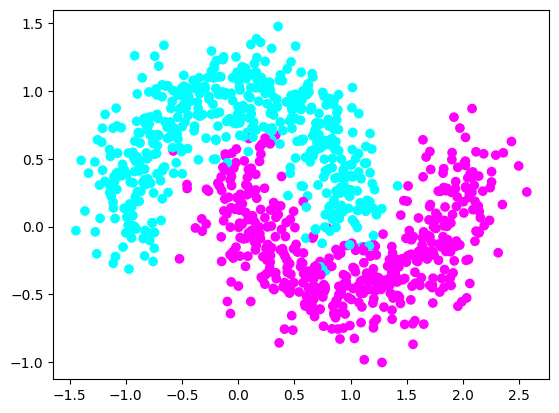

In [39]:
# Visualize the dataframe
plt.scatter(x=moons["X0"], # Plot the first feature on the x-axis
            y=moons["X1"], # Plot the second feature on the y-axis
            c=y,
            cmap="cool",)

In [55]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

TypeError: expected np.ndarray (got Tensor)

In [56]:
# Create train and test splits

X_train, X_test, y_train, y_test = train_test_split(X, # Creates train and test splits of features
                                                    y, # Creates train and test splits of labels
                                                    test_size=0.2, # 20% of the data will be used for testing
                                                    random_state=random_state) # Set random state for reproducibility

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

* Feel free to use any combination of PyTorch layers (linear and non-linear) you w

In [ ]:
# Create model 
class MoonModelV0(nn.Module):
    def __init__(self):
        super().__init__()
    
        # Create layers
        self.layer_1 = nn.Linear(in_features=2,
                                 out_features=16) # 2 input features, 16 output features
    
        self.layer_2 = nn.Linear(in_features=16,
                                 out_features=16) # 116 input features, 16 output feature
    
        self.layer_3 = nn.Linear(in_features=16,
                                 out_features=1) # 16 input features, 1 output feature
    
        self.relu = nn.ReLU() # Create ReLU activation function

    def forward(self, x:torch.tensor) -> torch.tensor:
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    

model_0 = MoonModelV0().to(device) # Create model instance and send it to device

model_0

MoonModelV0(
  (layer_1): Linear(in_features=2, out_features=16, bias=True)
  (layer_2): Linear(in_features=16, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

## 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [ ]:
# loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss function

# optimizer
optimizer = torch.optim.SGD(params=model_0.parameters(), # update the parameters of model_0
                            lr=0.1) # learning rate of 0.1 

## 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.

* To measure model accuracy, you can create your own accuracy function or use the accuracy function in TorchMetrics.
* Train the model for long enough for it to reach over 96% accuracy.
* The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.*


In [ ]:
# accuracy function
from torchmetrics.classification import BinaryAccuracy

# setup accuracy metric
accuracy = BinaryAccuracy().to(device) * 100 # MUltiply by 100 to get percentage


In [85]:
# Create training & testing loop

# How many loops through the data
epochs = 100 

# Bring data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

model_0.to(device) 

for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze() # Forward pass through the model, squeeze to remove extra dimensions
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> probabilities -> labels

    # 2. calculathe loss and accuracy
    loss = loss_fn(y_logits, y_train)
    acc = accuracy(y_pred, y_train)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. back propagation
    loss.backward()

    # 5. optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> probabilities -> labels

        # 2. calculate test loss & test accuracy
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy(test_pred, y_test)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Acc: {acc:.4f}% | Test Loss: {test_loss:.5f} | Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06068 | Test Acc: 96.50%
Epoch: 10 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06068 | Test Acc: 96.50%
Epoch: 20 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06068 | Test Acc: 96.50%
Epoch: 30 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 40 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 50 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 60 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 70 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 80 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%
Epoch: 90 | Loss: 0.08 | Acc: 96.8750% | Test Loss: 0.06067 | Test Acc: 96.50%


## 5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [ ]:
model_0.eval() # Set model to evaluation mode
with torch.inference_mode():
    y_logits_preds = model_0(X_test).squeeze() # Forward pass through the model



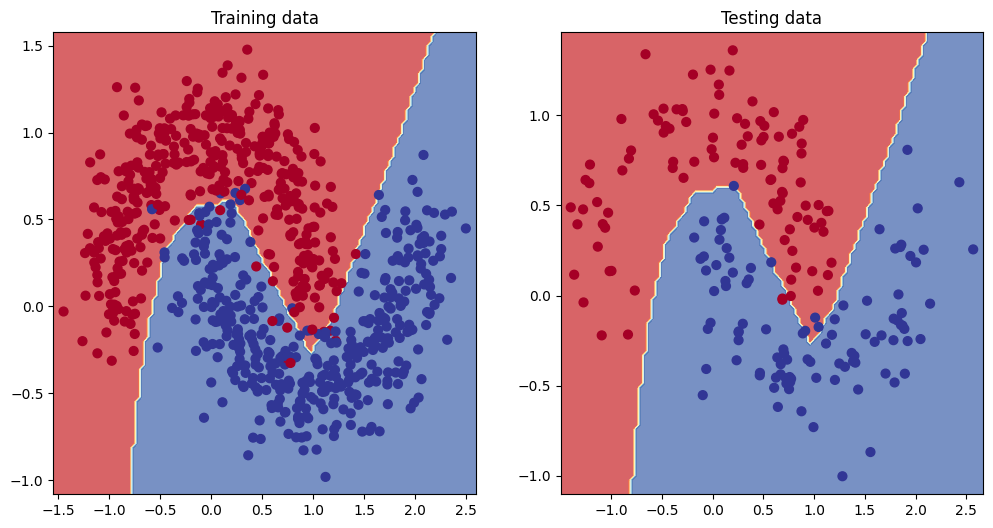

In [ ]:
# Import function to plot decision boundary
from helper_functions import plot_decision_boundary

# Plot data
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Testing data")
plot_decision_boundary(model_0, X_test, y_test)

## 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

* Feel free to reference the ML cheatsheet website for the formula: *https://ml-cheatsheet.readthedocs.io/en/latest/activation_functions.html#tanh*
